In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow.keras import layers, models
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error
import statsmodels.api as sm
import plotly.express as px
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
data = pd.read_excel('Natural_Gas_Spot_Price.xlsx')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6505 entries, 0 to 6504
Data columns (total 2 columns):
 #   Column                                                      Non-Null Count  Dtype         
---  ------                                                      --------------  -----         
 0   Date                                                        6505 non-null   datetime64[ns]
 1   Henry Hub Natural Gas Spot Price (Dollars per Million Btu)  6504 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 101.8 KB


In [3]:
data = data.rename(
    columns={
        "Henry Hub Natural Gas Spot Price (Dollars per Million Btu)":"gas_price",
        "Date":"date"
    }
)

data.head(10)
data['date'] = pd.to_datetime(data['date'], format = "%d/%m/%Y")

In [4]:
data = data.set_index('date')

MISSING VALUES

In [5]:
print(data.isnull().sum())

gas_price    1
dtype: int64


In [6]:
data = data.fillna(method = 'pad')
print(data.isnull().sum())

gas_price    0
dtype: int64


In [7]:
fig = px.line(data, title = 'Natural Gas Spot Prices', template = 'plotly_dark')
fig.show()

In [8]:
# fig = px.histogram(data, x = "gas_price", template = 'plotly_dark')
# fig.show()

In [9]:
def test_stationarity(timeseries):
    
    # Determing rolling statistics
    rolmean = timeseries.rolling(25).mean()
    rolstd = timeseries.rolling(25).std()

    # Plot rolling statistics:
    plt.figure(figsize = (20,10))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        
    print(dfoutput)

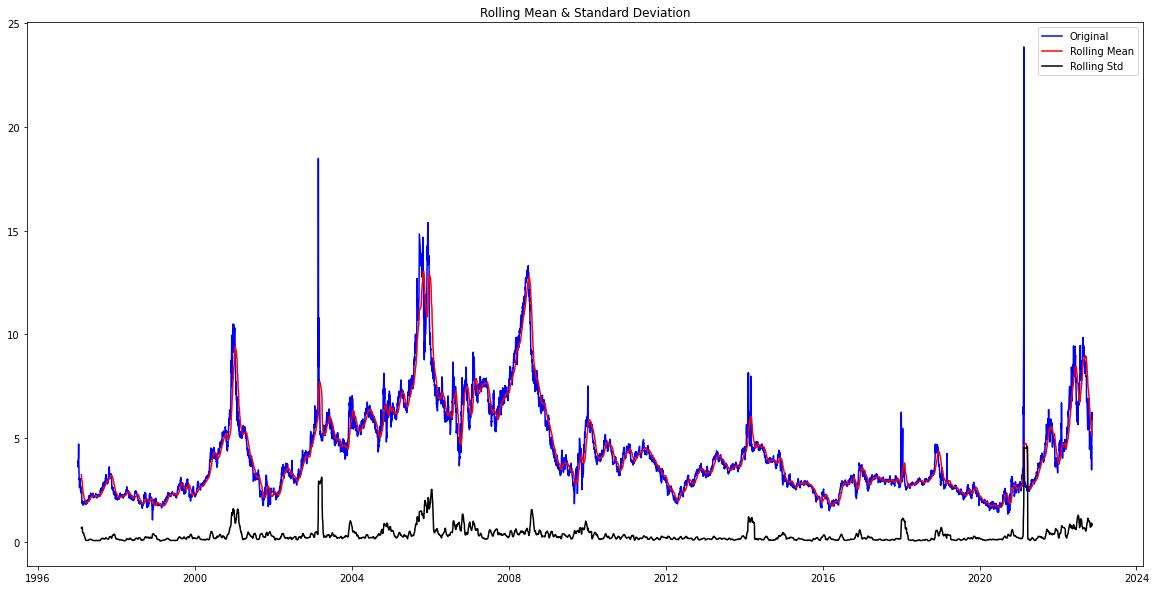

Results of Dickey-Fuller Test:
Test Statistic                   -4.027811
p-value                           0.001272
#Lags Used                        7.000000
Number of Observations Used    6497.000000
Critical Value (1%)              -3.431357
Critical Value (5%)              -2.861985
Critical Value (10%)             -2.567007
dtype: float64


In [10]:
test_stationarity(data)

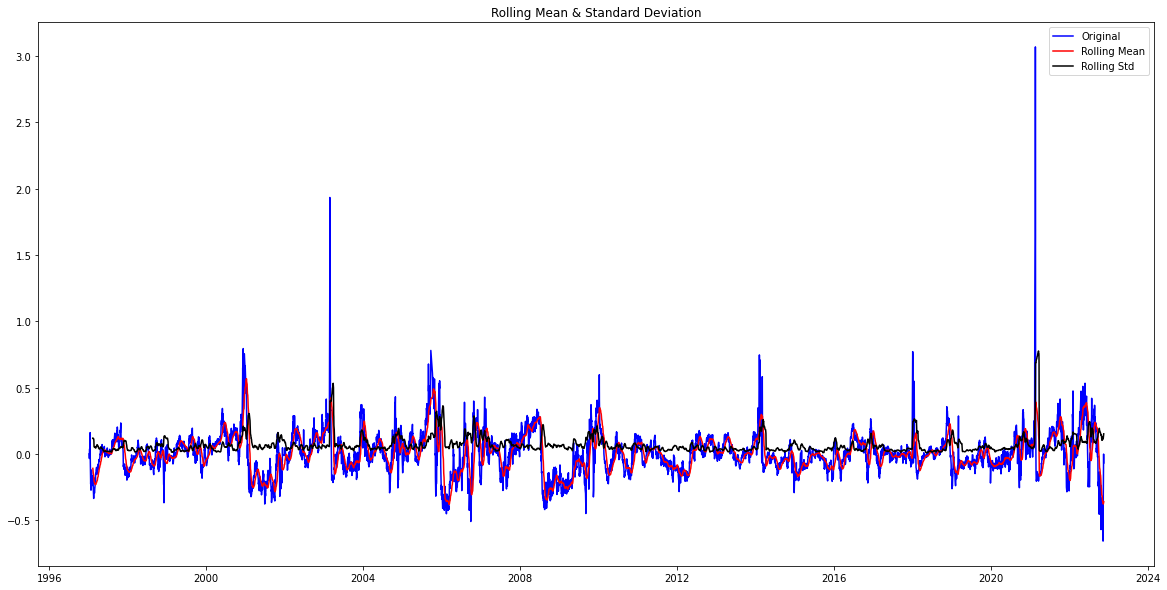

Results of Dickey-Fuller Test:
Test Statistic                -1.135745e+01
p-value                        9.656267e-21
#Lags Used                     1.000000e+01
Number of Observations Used    6.494000e+03
Critical Value (1%)           -3.431357e+00
Critical Value (5%)           -2.861985e+00
Critical Value (10%)          -2.567007e+00
dtype: float64


In [11]:
ts_sqrt = np.sqrt(data)
expwighted_avg = ts_sqrt.ewm(halflife = 25).mean()

ts_sqrt_ewma_diff = ts_sqrt - expwighted_avg
test_stationarity(ts_sqrt_ewma_diff)

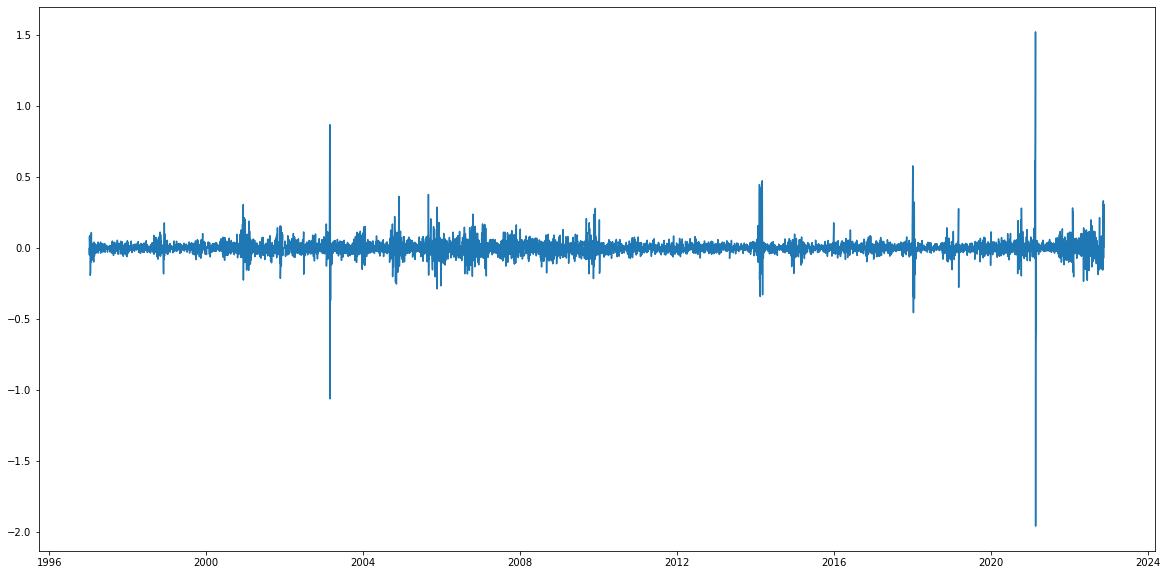

In [12]:
ts_sqrt_diff = ts_sqrt - ts_sqrt.shift()

plt.figure(figsize = (20,10))
plt.plot(ts_sqrt_diff)
plt.show()

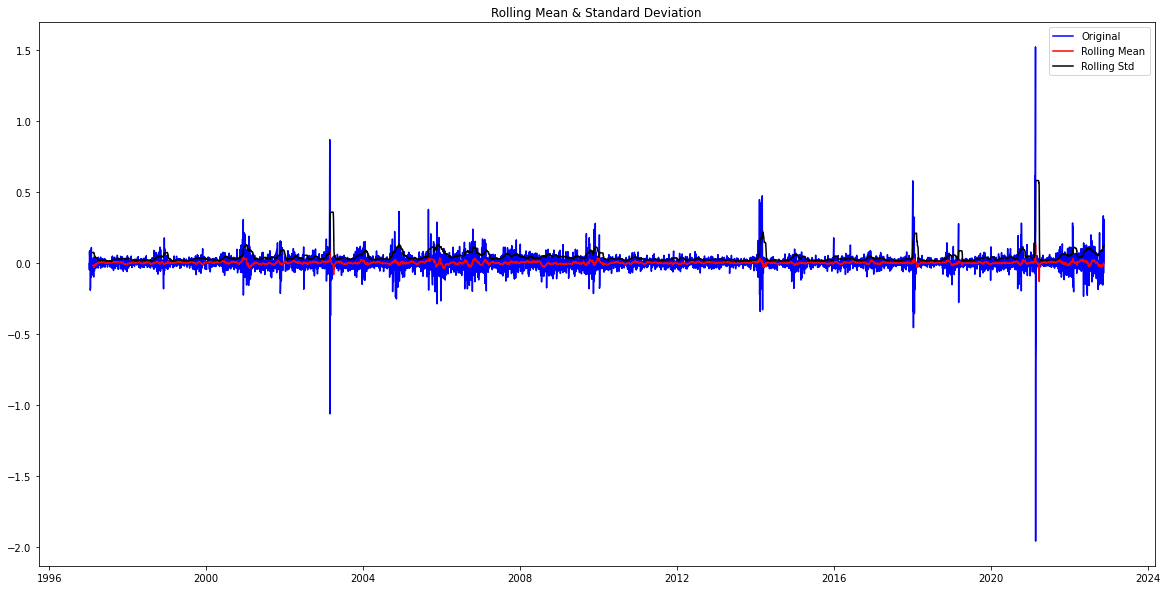

Results of Dickey-Fuller Test:
Test Statistic                  -40.648140
p-value                           0.000000
#Lags Used                        5.000000
Number of Observations Used    6498.000000
Critical Value (1%)              -3.431357
Critical Value (5%)              -2.861985
Critical Value (10%)             -2.567007
dtype: float64


In [13]:
ts_sqrt = np.sqrt(data)
ts_sqrt_diff = ts_sqrt - ts_sqrt.shift()
ts_sqrt_diff.dropna(inplace = True)
test_stationarity(ts_sqrt_diff)

DATA SPLITTING

In [14]:
data = data.sort_values(by = 'date')

train = data['1997-01-06': '2020-01-06'] # 7 Jan 1997 to 6 Jan 2021 
test = data['2020-01-07': '2022-11-15'] # 7 Jan 2021  to 1 Mar 2022 

print("Length of Train Data: ", len(train))
print("Length of Test Data: ", len(test)) 

Length of Train Data:  5783
Length of Test Data:  722


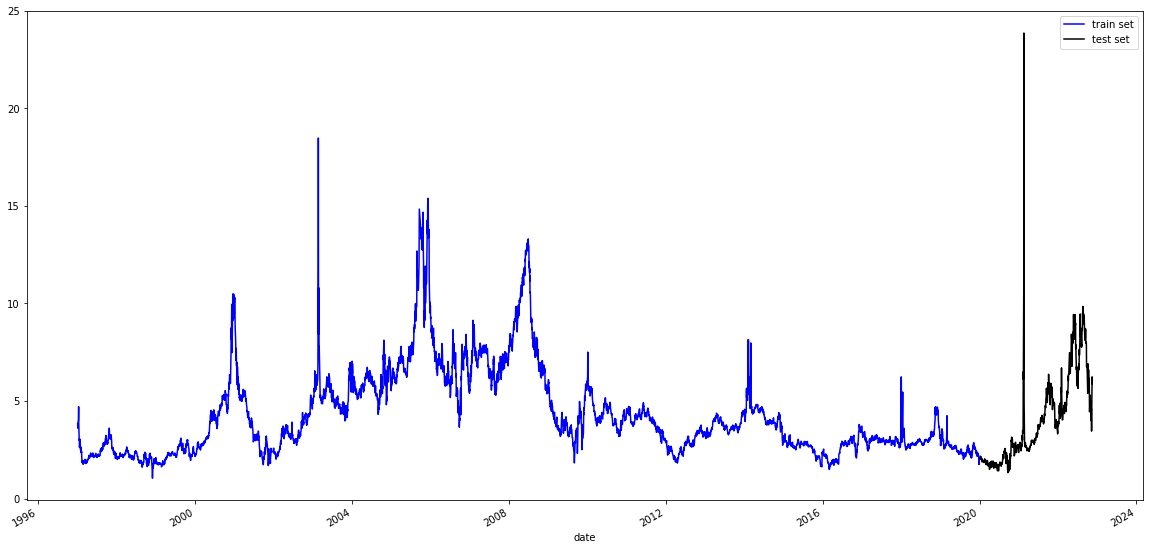

In [15]:
ax = train.plot(figsize = (20, 10), color = 'b')
test.plot(ax = ax, color = 'black')
plt.legend(['train set', 'test set'])
plt.show()

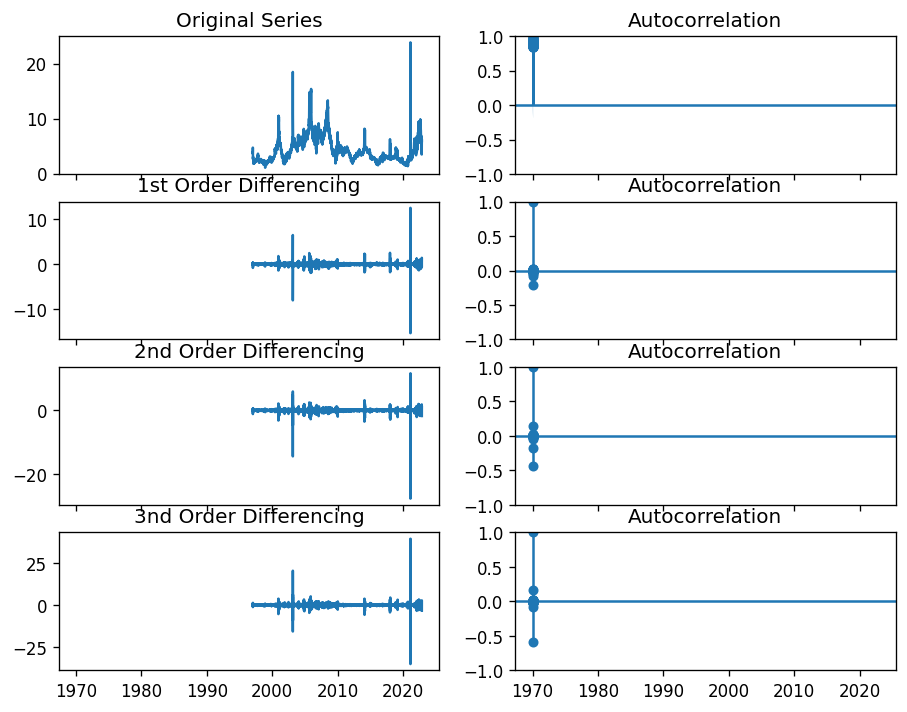

In [16]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(4, 2, sharex=True)
axes[0, 0].plot(data.gas_price); axes[0, 0].set_title('Original Series')
plot_acf(data.gas_price, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(data.gas_price.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(data.gas_price.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(data.gas_price.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(data.gas_price.diff().diff().dropna(), ax=axes[2, 1])

# 3rd Differencing
axes[3, 0].plot(data.gas_price.diff().diff().diff()); axes[3, 0].set_title('3nd Order Differencing')
plot_acf(data.gas_price.diff().diff().diff().dropna(), ax=axes[3, 1])

plt.show()

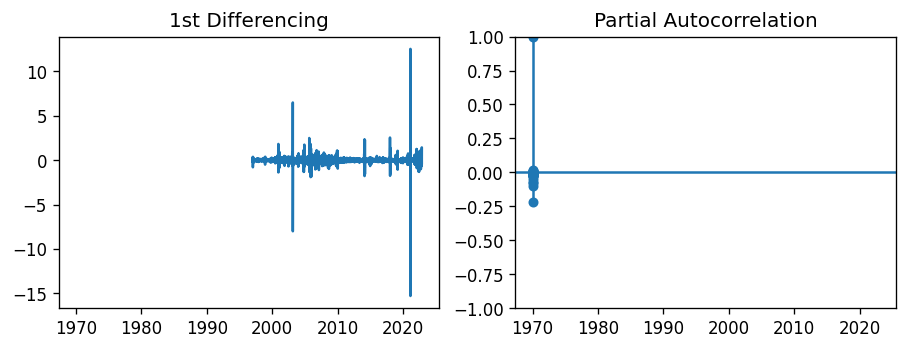

In [17]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(data.gas_price.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(data.gas_price.diff().dropna(), ax=axes[1])

plt.show()

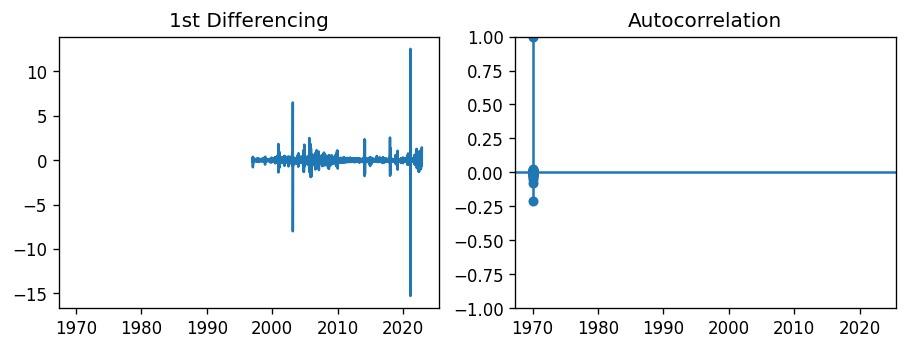

In [18]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)

axes[0].plot(data.gas_price.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(data.gas_price.diff().dropna(), ax=axes[1])

plt.show()

In [19]:
# DO I FIT THIS DATA WITH DATA OR TRAIN
model = sm.tsa.arima.ARIMA(data, order = (3, 1, 2))
arima_model = model.fit() 
print(arima_model.summary())

c:\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                               SARIMAX Results                                
Dep. Variable:              gas_price   No. Observations:                 6505
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -2636.974
Date:                Wed, 29 Mar 2023   AIC                           5285.947
Time:                        10:49:57   BIC                           5326.628
Sample:                             0   HQIC                          5300.017
                               - 6505                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1280      0.034      3.737      0.000       0.061       0.195
ar.L2          0.2045      0.020     10.341      0.000       0.166       0.243
ar.L3          0.0598      0.009      6.903      0.0

In [20]:
print('RMSE:', np.sqrt(np.mean((arima_model.resid.values)**2)))

RMSE: 0.3659923128472946


In [21]:
yp_train = arima_model.predict(start = 0, end = (len(train)-1))
yp_test = arima_model.predict(start='2020-01-07', end='2022-11-15') 

print("Train Data:\nMean Square Error: {}".format(mean_squared_error(train, yp_train)))
print("\nTest Data:\nMean Square Error: {}".format(mean_squared_error(test, yp_test)))

Train Data:
Mean Square Error: 0.0728724624216204

Test Data:
Mean Square Error: 0.6231658263055591


In [22]:
print(yp_test)

date
2020-01-07    2.103568
2020-01-08    2.152275
2020-01-09    2.082127
2020-01-10    2.067187
2020-01-13    2.054968
                ...   
2022-11-09    3.967009
2022-11-10    3.743663
2022-11-11    4.798390
2022-11-14    4.583156
2022-11-15    6.118592
Name: predicted_mean, Length: 722, dtype: float64


In [23]:
print(test)

            gas_price
date                 
2020-01-07       2.17
2020-01-08       2.09
2020-01-09       2.05
2020-01-10       2.05
2020-01-13       2.03
...               ...
2022-11-09       3.46
2022-11-10       4.80
2022-11-11       4.80
2022-11-14       6.24
2022-11-15       5.90

[722 rows x 1 columns]


In [24]:
print(yp_train)

date
1997-01-07    0.000000
1997-01-08    3.820000
1997-01-09    3.801485
1997-01-10    3.631626
1997-01-13    3.933141
                ...   
2019-12-30    1.807572
2019-12-31    2.126197
2020-01-02    2.035823
2020-01-03    2.081955
2020-01-06    2.053847
Name: predicted_mean, Length: 5783, dtype: float64


In [25]:
print(train)

            gas_price
date                 
1997-01-07       3.82
1997-01-08       3.80
1997-01-09       3.61
1997-01-10       3.92
1997-01-13       4.00
...               ...
2019-12-30       2.06
2019-12-31       2.09
2020-01-02       2.05
2020-01-03       2.06
2020-01-06       2.10

[5783 rows x 1 columns]


In [26]:
b = pd.DataFrame(yp_test)
b.rename(columns = {0: 'ARIMA_pred'}, inplace = True)

# a.index = train.iloc[slot:].index
test_compare = pd.concat([test, b], 1)
test_compare

,gas_price,predicted_mean
date,,
2020-01-07,2.17,2.103568
2020-01-08,2.09,2.152275
2020-01-09,2.05,2.082127
2020-01-10,2.05,2.067187
2020-01-13,2.03,2.054968
...,...,...
2022-11-09,3.46,3.967009
2022-11-10,4.80,3.743663
2022-11-11,4.80,4.798390


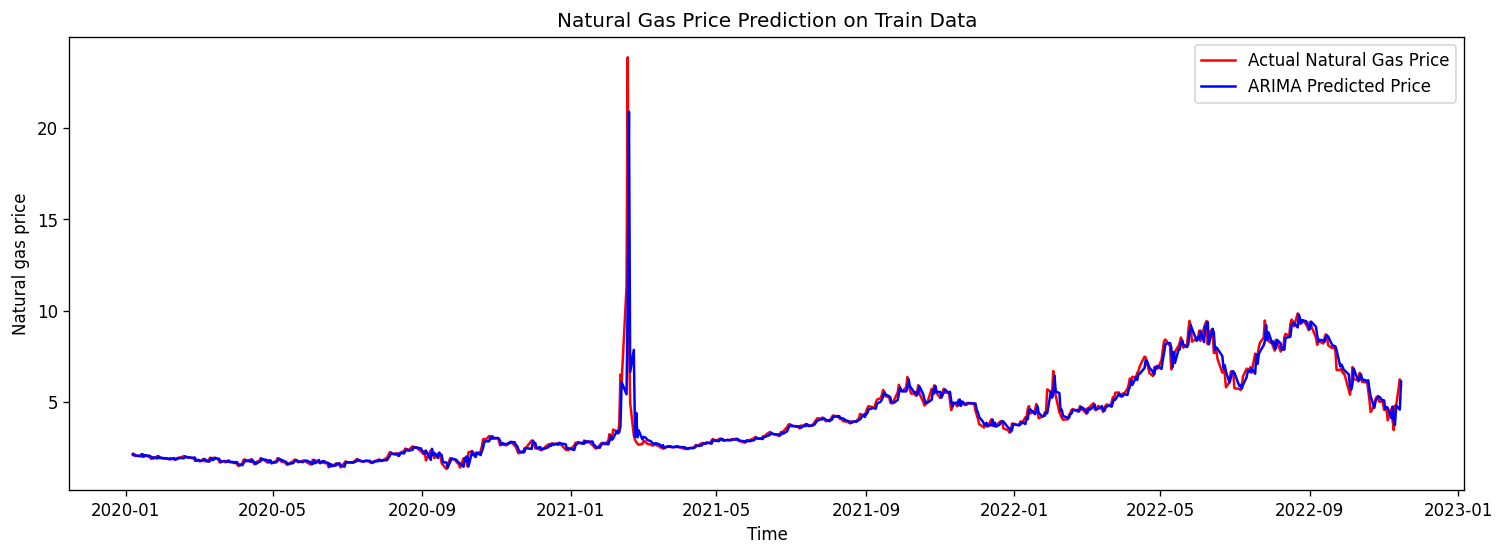

In [27]:
plt.figure(figsize = (15, 5))
plt.plot(test_compare['gas_price'], color = 'red', label = "Actual Natural Gas Price")
plt.plot(test_compare['predicted_mean'], color = 'blue', label = 'ARIMA Predicted Price')
plt.title("Natural Gas Price Prediction on Train Data")
plt.xlabel('Time')
plt.ylabel('Natural gas price')
plt.legend(loc = 'best')
plt.show()

In [28]:
arima_mae = mean_absolute_error(test, yp_test)
arima_mse = mean_squared_error(test, yp_test)
arima_rmse = np.sqrt(arima_mse)

# print the performance metrics
print('ARIMA Performance Metrics:')
print('MAE:', arima_mae)
print('MSE:', arima_mse)
print('RMSE:', arima_rmse)

ARIMA Performance Metrics:
MAE: 0.22887252972291028
MSE: 0.6231658263055591
RMSE: 0.7894085294101901


In [29]:
mape = []
for index,row in test_compare.iterrows():
    # value = row[0]
    # print(value)
    a = np.mean(np.abs((row[0] - row[1]) / row[0])) * 100
    mape.append(a)
avg = sum(mape)/len(mape)
print('MAPE: %.2f%%' % avg)

MAPE: 4.99%


In [30]:
pred_uc = arima_model.get_forecast(steps=66)
pred_ci = pred_uc.conf_int()

c:\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [31]:
pred_values = pred_uc.predicted_mean
pred_values

6505    5.483078
6506    5.541104
6507    5.442946
6508    5.417326
6509    5.397444
          ...   
6566    5.363816
6567    5.363816
6568    5.363816
6569    5.363816
6570    5.363816
Name: predicted_mean, Length: 66, dtype: float64

In [32]:
slot = 15

x_train = []
y_train = []

for i in range(slot, len(train)):
    x_train.append(train.iloc[i-slot:i, 0])
    y_train.append(train.iloc[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape, y_train.shape)

(5768, 15, 1) (5768,)


In [33]:
lstm_model = tf.keras.Sequential()
lstm_model.add(tf.keras.layers.LSTM(units = 50, input_shape = (slot, 1), return_sequences = True, activation = 'relu'))
#lstm_model.add(tf.keras.layers.Dropout(0.01))
lstm_model.add(tf.keras.layers.LSTM(units = 50, activation = 'relu', return_sequences = True))
#lstm_model.add(tf.keras.layers.Dropout(0.01))
lstm_model.add(tf.keras.layers.LSTM(units = 50, return_sequences = True))
#lstm_model.add(tf.keras.layers.Dropout(0.01))
lstm_model.add(tf.keras.layers.LSTM(units = 50, return_sequences = False))
#lstm_model.add(tf.keras.layers.Dropout(0.01))
lstm_model.add(tf.keras.layers.Dense(units = 1))
lstm_model.compile(loss = 'mean_squared_error', optimizer = 'adam')

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 15, 50)            20200     
                                                                 
 lstm_2 (LSTM)               (None, 15, 50)            20200     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


In [34]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 7)

history = lstm_model.fit(x_train, y_train, epochs = 100, 
                         batch_size = 64, 
                         verbose = 1, shuffle = False, 
                         callbacks = [early_stopping])

Epoch 1/100
91/91 [==============================] - 17s 69ms/step - loss: 4.8442
Epoch 2/100
91/91 [==============================] - 7s 72ms/step - loss: 4.6904
Epoch 3/100
91/91 [==============================] - 7s 72ms/step - loss: 4.0923
Epoch 4/100
91/91 [==============================] - 6s 69ms/step - loss: 3.1767
Epoch 5/100
91/91 [==============================] - 6s 70ms/step - loss: 2.3457
Epoch 6/100
91/91 [==============================] - 6s 68ms/step - loss: 1.7168
Epoch 7/100
91/91 [==============================] - 6s 70ms/step - loss: 1.1789
Epoch 8/100
91/91 [==============================] - 6s 67ms/step - loss: 0.8348
Epoch 9/100
91/91 [==============================] - 7s 74ms/step - loss: 0.6610
Epoch 10/100
91/91 [==============================] - 6s 71ms/step - loss: 0.5555
Epoch 11/100
91/91 [==============================] - 7s 72ms/step - loss: 0.4871
Epoch 12/100
91/91 [==============================] - 6s 71ms/step - loss: 0.4447
Epoch 13/100
91/91 [====

In [35]:
yp_train = lstm_model.predict(x_train)
a = pd.DataFrame(yp_train)
a.rename(columns = {0: 'gp_pred'}, inplace = True); 
a.index = train.iloc[slot:].index
train_compare = pd.concat([train.iloc[slot:], a], 1)

181/181 [==============================] - 9s 25ms/step


In [36]:
train_compare.head(3)

,gas_price,gp_pred
date,,
1997-01-28,3.05,2.912783
1997-01-29,2.91,3.009520
1997-01-30,2.86,3.016928


In [37]:
train_compare.tail(3)

,gas_price,gp_pred
date,,
2020-01-02,2.05,2.162918
2020-01-03,2.06,2.183502
2020-01-06,2.10,2.200775


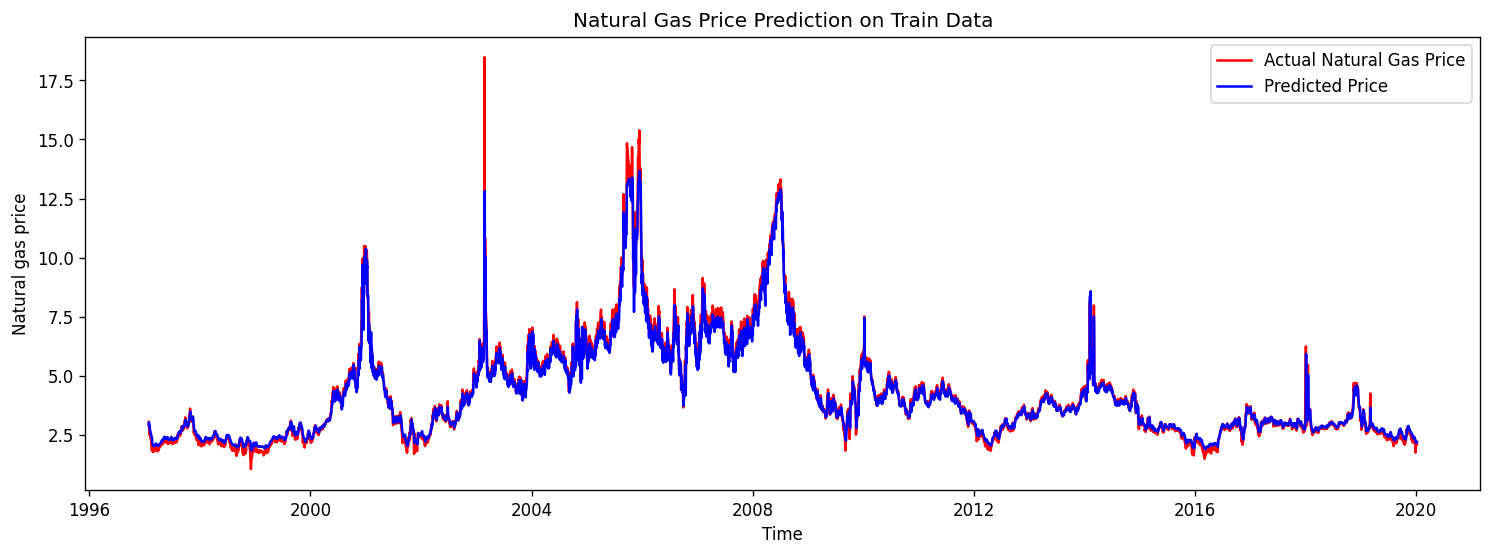

In [38]:
plt.figure(figsize = (15, 5))
plt.plot(train_compare['gas_price'], color = 'red', label = "Actual Natural Gas Price")
plt.plot(train_compare['gp_pred'], color = 'blue', label = 'Predicted Price')
plt.title("Natural Gas Price Prediction on Train Data")
plt.xlabel('Time')
plt.ylabel('Natural gas price')
plt.legend(loc = 'best')
plt.show()

In [39]:
dataset_total = pd.concat((train, test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test)- slot:].values
inputs = inputs.reshape(-1, 1)

x_test = []
y_test = []
for i in range (slot, len(test)+slot): #Test+15
    x_test.append(inputs[i-slot:i, 0])
    y_test.append(train.iloc[i, 0])
      
x_test, y_test = np.array(x_test), np.array(y_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
pred_price = lstm_model.predict(x_test)

23/23 [==============================] - 1s 20ms/step


In [40]:
b = pd.DataFrame(pred_price)
b.rename(columns = {0: 'gp_pred'}, inplace = True); 
b.index = test.index
test_compare = pd.concat([test, b], 1)

In [41]:
test_compare.head(3)

,gas_price,gp_pred
date,,
2020-01-07,2.17,2.218156
2020-01-08,2.09,2.246196
2020-01-09,2.05,2.256503


In [42]:
test_compare.tail(3)

,gas_price,gp_pred
date,,
2022-11-11,4.80,4.525299
2022-11-14,6.24,4.718144
2022-11-15,5.90,6.100637


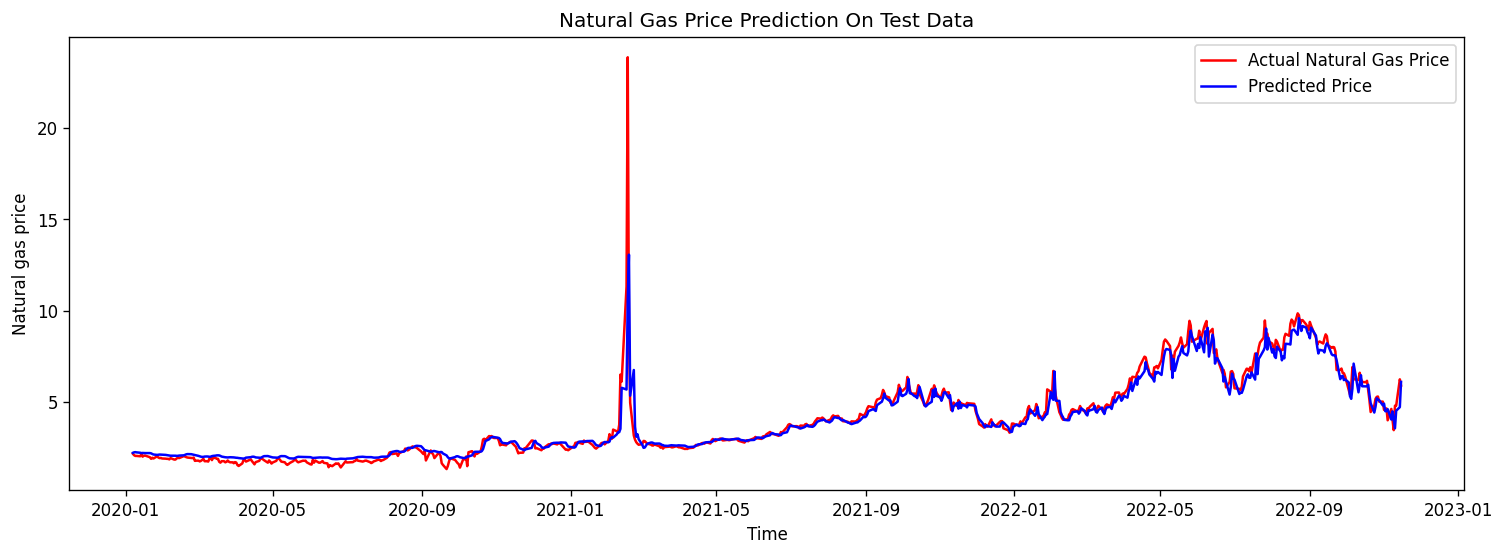

In [43]:
plt.figure(figsize = (15,5))
plt.plot(test_compare['gas_price'], color = 'red', label = "Actual Natural Gas Price")
plt.plot(test_compare['gp_pred'], color = 'blue', label = 'Predicted Price')
plt.title("Natural Gas Price Prediction On Test Data")
plt.xlabel('Time')
plt.ylabel('Natural gas price')
plt.legend(loc = 'best')
plt.show()

In [44]:
mse_train = mean_squared_error(train_compare['gas_price'], train_compare['gp_pred'])
mse_test = mean_squared_error(test_compare['gas_price'], test_compare['gp_pred'])

r2_train = r2_score(train_compare['gas_price'], train_compare['gp_pred'])
r2_test = r2_score(test_compare['gas_price'], test_compare['gp_pred'])

print("Train Data:\nMSE: {}\nR Square: {}".format(mse_train, r2_train))
print("\nTest Data:\nMSE: {}\nR Square: {}".format(mse_test, r2_test))

Train Data:
MSE: 0.09834723443985761
R Square: 0.9794350421846599

Test Data:
MSE: 0.46945119302553406
R Square: 0.9115773238446204


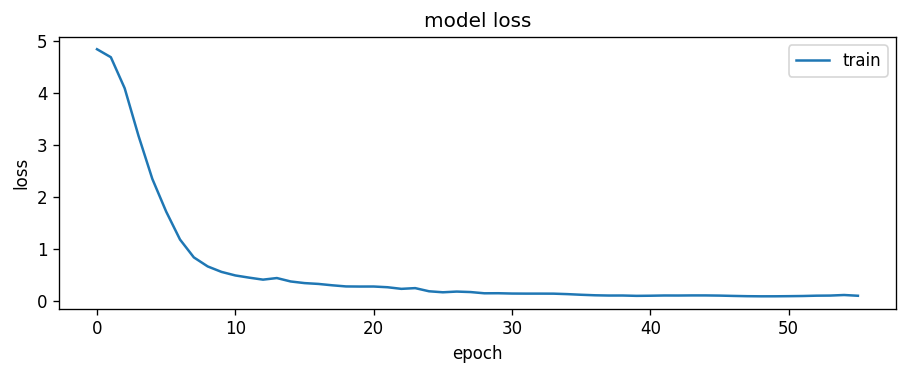

In [45]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

In [46]:
forecast = pd.DataFrame({'date': pd.date_range(start = '11/15/2022', end = '22/2/2023')}) # 2 March to 20 March 

inputs = test[len(test) - slot: ].values

for i in range(slot, len(forecast)): 
    inputs = inputs.T
    inputs = np.reshape(inputs, (inputs.shape[0], inputs.shape[1], 1))
    pred_price = lstm_model.predict(inputs[:,i-slot:i])
    inputs = np.append(inputs, pred_price)
    inputs = np.reshape(inputs, (inputs.shape[0], 1))

forecast['gp_pred'] = inputs
forecast = forecast.set_index('date')

1/1 [==============================] - 0s 63ms/step


In [50]:
forecast = forecast.reset_index()

In [51]:
forecast

,date,gp_pred,gas_price
0,2022-11-15,5.280000,NaN
1,2022-11-16,5.300000,NaN
2,2022-11-17,5.020000,NaN
3,2022-11-18,5.020000,NaN
4,2022-11-19,4.570000,NaN
...,...,...,...
95,2023-02-18,3.212116,NaN
96,2023-02-19,3.211190,NaN
97,2023-02-20,3.210316,NaN
98,2023-02-21,3.209492,NaN


In [53]:
data1

,date,gas_price
0,2022-11-16,5.88
1,2022-11-17,6.20
2,2022-11-18,6.10
3,2022-11-21,6.23
4,2022-11-22,6.27
...,...,...
61,2023-02-15,2.45
62,2023-02-16,2.48
63,2023-02-17,2.28
64,2023-02-21,2.12


In [55]:
data1 = pd.read_csv('forecast.csv')

data1 = data1.drop('predicted_mean', axis=1)


forecast['date'] = pd.to_datetime(forecast['date'])
data1['date'] = pd.to_datetime(data1['date'])

df_merged = pd.merge(data1, forecast[['date', 'gp_pred']], on='date', how='inner')
df_merged

,date,gas_price,gp_pred
0,2022-11-16,5.88,5.300000
1,2022-11-17,6.20,5.020000
2,2022-11-18,6.10,5.020000
3,2022-11-21,6.23,4.650000
4,2022-11-22,6.27,4.000000
...,...,...,...
61,2023-02-15,2.45,3.215244
62,2023-02-16,2.48,3.214140
63,2023-02-17,2.28,3.213099
64,2023-02-21,2.12,3.209492


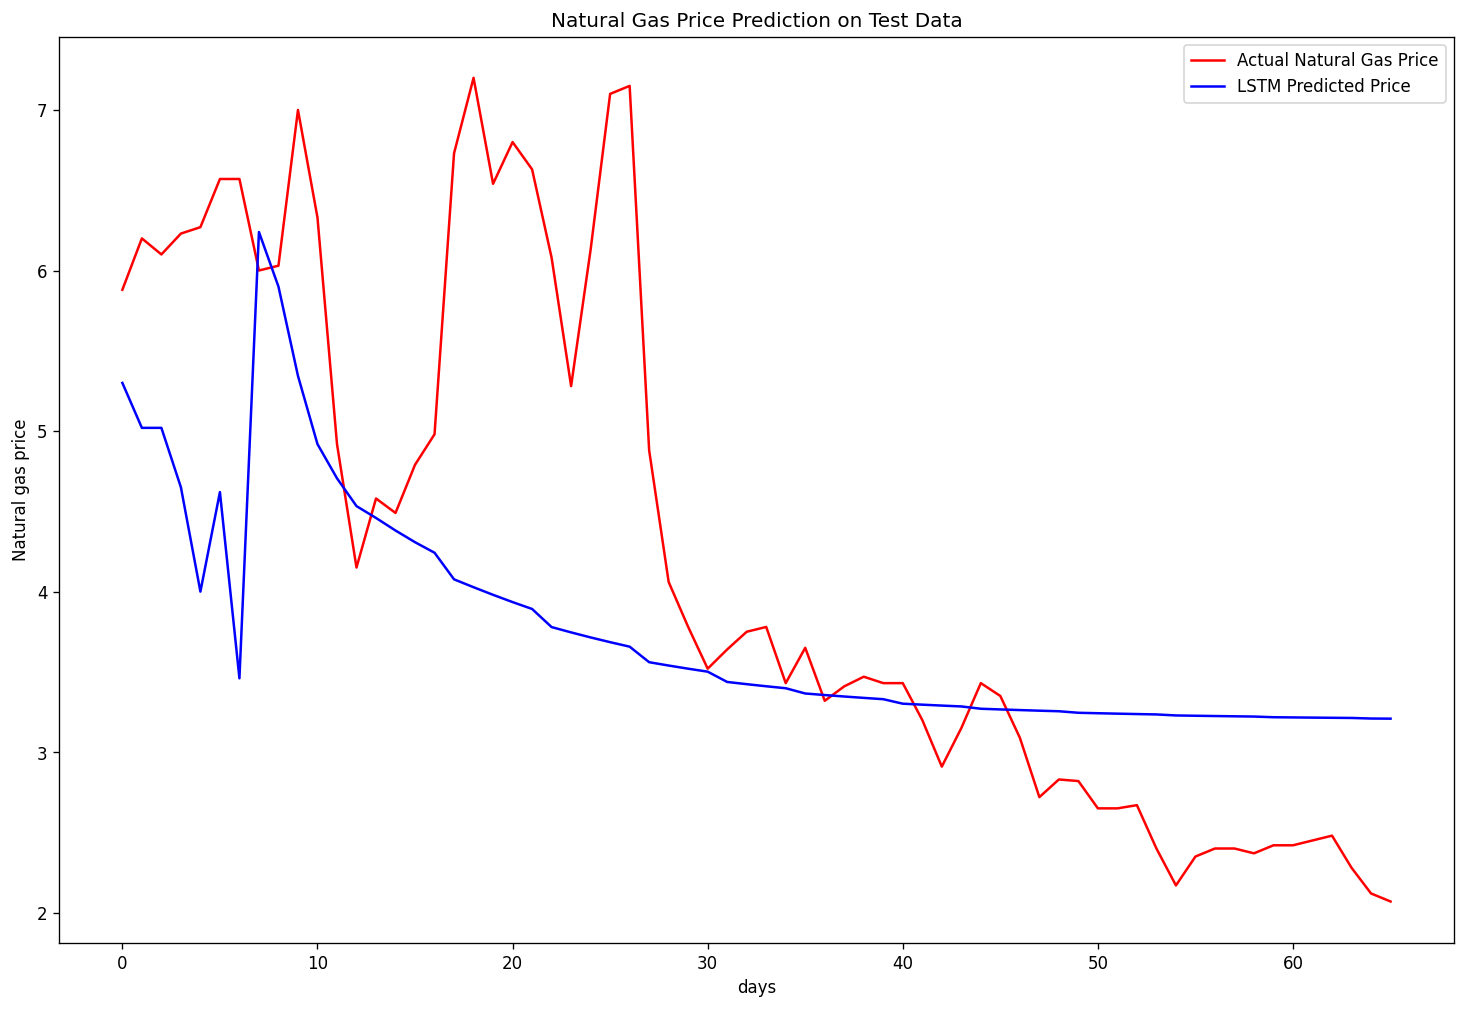

In [56]:
plt.figure(figsize = (15, 10))
plt.plot(df_merged['gas_price'], color = 'red', label = "Actual Natural Gas Price")
plt.plot(df_merged['gp_pred'], color = 'blue', label = 'LSTM Predicted Price')
plt.title("Natural Gas Price Prediction on Test Data")
plt.xlabel('days')
plt.ylabel('Natural gas price')
plt.legend(loc = 'best')
plt.show()

In [57]:
mean_squared_error(df_merged['gas_price'], df_merged['gp_pred'])

1.8387110331669525

# **LSTM: 1.8387110331669525** <BR>
## PROPHET: 3.902730877730345 <BR>
### SARIMA WITHOUT DIFFERENCING: 5.070678474597258 <BR>
#### SARIMA WITH DIFFERENCING: 11.933490787403052 
